# Computational Social Science Project #2 

**Enter your Name:** Neha Malhotra

*Semester:* Fall 2025


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [56]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [58]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("/Users/apple/Desktop/computational_social_science/Computational-Social-Science-Projects/Project-2/Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [60]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


##### Shape means the size of the dataset. In this dataset, it has 3220 rows and 95 columns

In [62]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [64]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['Suppressed']


In [66]:
#

# Now do the same as above, but for "Obesity_Number"
print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique())


['No Data']


In [68]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
print(diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]['Physical_Inactivity_Number'].unique())



['No Data']


##### The output 'No Data' suggests that there were no non-numeric values in the Obesity_Number and Physical_Inactivity_Number columns. Diabetes_Number shows a suppressed value which means it had non-numeric values. 

These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [70]:
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 

# Physical Inactivity
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"]
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int)

# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

##### The above code cleaned data by removing non-numeric entries in target columns and converting them to appropriate numeric types for analysis

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [72]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [74]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


##### The above output shows that most rate columns are bounded between 0 and 1, which confirms they are scaled appropriately as proportion. 

##### For example, Diabetes, Obesity, and Physical Inactivity Rates: These are scaled and range between 0 and 1, making them proportional to county populations.Sex Ratios and Population Totals: Sex ratios and total population values exceed 1, which is expected for demographic metrics and unscaled total population counts.

##### Population Percentages by Race/Ethnicity: Most columns related to racial/ethnic group percentages are bounded between 0 and 1, indicating successful scaling

#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [76]:
#
# Check for duplicate columns
#-----------
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population',
 'sex and age_total population_18 years and over_1',
 'hispanic or latino and race_total population',
 'sex and age_total population_65 years and over_1',
 'race_total population_one race_1',
 'race_total population_two or more races_1']

In [78]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(['sex and age_total population_18 years and over_1',
                          'race_total population_one race_1',
                          'sex and age_total population',
                          'race_total population_two or more races_1',
                          'sex and age_total population_65 years and over_1',
                          'hispanic or latino and race_total population'], axis=1)

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [80]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

##### The above code replaces individual states with border US regions to reduce the dataset's sparsity when creating dummy variables. This code makes the dataset simpler for analysis 

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

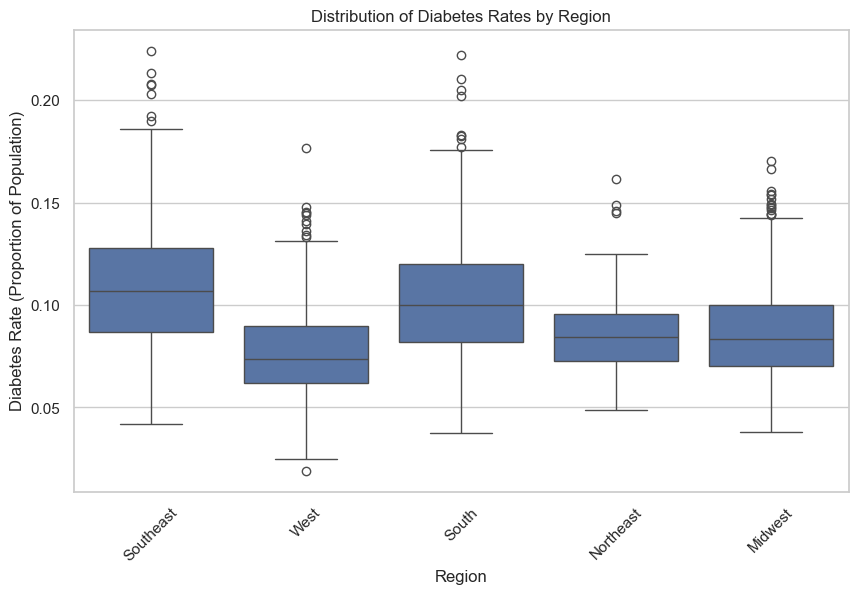

In [82]:
# EDA #1 and interpretations in this section 
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visual style
sns.set(style="whitegrid")

# 1. Boxplot: Distribution of Diabetes Rates by Region
plt.figure(figsize=(10, 6))
sns.boxplot(data=diabetes, x='Region', y='Diabetes_Number')
plt.title('Distribution of Diabetes Rates by Region')
plt.xlabel('Region')
plt.ylabel('Diabetes Rate (Proportion of Population)')
plt.xticks(rotation=45)
plt.show()

##### Boxplot reveals regional differences in diabetes rates in the U.S. Some of the key observations are as follows:

##### 1. Higher Median Diabetes Rates: The Southeast and South regions have higher median diabetes rates compared to other regions. In contrast, the Northeast and West regions exhibit lower median diabetes rates. Additionally, there is a broader range of diabetes rates in the Southeast and South, with several outliers reflecting counties with particularly high diabetes prevalence.
##### 2. Lower and more consistent rates in the Midwest and Northeast regions: These regions show a more consistent range, implying relatively stable diabetes rates across counties in these areas. 

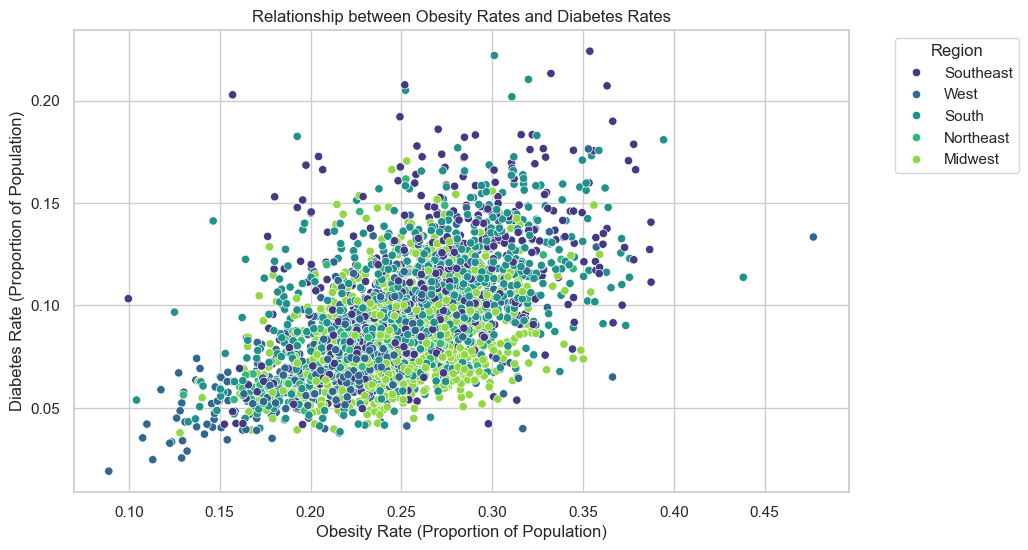

In [84]:
#
# EDA #2 and interpretations in this section 
import matplotlib.pyplot as plt
import seaborn as sns

# Scatterplot: Diabetes Number vs Obesity Number
plt.figure(figsize=(10, 6))
sns.scatterplot(data=diabetes, x='Obesity_Number', y='Diabetes_Number', hue='Region', palette='viridis')
plt.title('Relationship between Obesity Rates and Diabetes Rates')
plt.xlabel('Obesity Rate (Proportion of Population)')
plt.ylabel('Diabetes Rate (Proportion of Population)')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##### The scatter plot reveals a strong positive correlation between obesity rates and diabetes rates, indicating that higher obesity rates are associated with higher diabetes prevalence across U.S. counties. Some of the key observations are as follows:
##### 1. Positive Correlation: Counties with high obesity rates tend to have higher diabetes rates, which means obesity is a strong predictor of diabetes.
##### 2. Regional Variation: Southeast and South (indicated by purple and dark blue points) show a concentration of counties with elevated obesity and diabetes rates, suggesting these areas may face greater health challenges related to lifestyle or socioeconomic factors. In contrast, the Northeast and Midwest regions (green points) tend to have lower obesity and diabetes rates, indicating relatively better health outcomes.
##### 3. Regions with elevated obesity rates may be prioritized for diabetes prevention programs due to the positive correlation

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [86]:
#

# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 


,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [88]:
#
# Partition data

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y ='Diabetes_Number'

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")

X = diabetes.drop(columns=['Diabetes_Number', 'race alone or in combination with one or more other races_total population'])


Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [90]:
# Feature selection
# Remove redundant or highly specific demographic features

y = 'Diabetes_Number'
irrelevant_features = [
    'race_total population_one race_american indian and alaska native_cherokee tribal grouping',
    'race_total population_one race_american indian and alaska native_chippewa tribal grouping',
    'race_total population_one race_american indian and alaska native_navajo tribal grouping',
    'race_total population_one race_american indian and alaska native_sioux tribal grouping',
    'race_total population_one race_some other race',
    'race alone or in combination with one or more other races_total population'
]

# Define X (features) and y (target)
X = diabetes_clean.drop(columns=[y] + irrelevant_features)
y = diabetes_clean[y]

##### In the above code I dropped highly specific demographic features. I dropped some of the redundant columns as well such as 'race alone or in combination with one or more other races_total population' as these columns are likely to overlap with other race-based features and do not add unique information. I kept the feature selection in alignment with the EDA findings, where I focused on features that show a clear relationship with diabetes like obesity, physical inactivity, etc. 

In [92]:
# Training/Test Split
# -------------------
# Split data into 80% training+validation and 20% test

from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(10)

# First split into temporary training+validation (80%) and test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Display shapes to verify
print("Temporary Training+Validation set shape:", X_temp.shape)
print("Test set shape:", X_test.shape)

Temporary Training+Validation set shape: (2489, 84)
Test set shape: (623, 84)


##### Temporary Training+Validation set shape: (2489, 84) means that this set consists of 80% of the original dataset and includes 84 features. By using a larger portion of the data here, we ensure that the model has enough data to learn effectively before final testing.
##### Test set shape: (623, 84): This set represents 20% of the data held for final evaluation. This ensures that once we choose the best-performing model (after validation), we can assess its generalization ability on this entirely unseen test set.

In [94]:
# Validation Split
# ----------------
# Further split the temporary training+validation set into 60% train and 20% validation

# Split the X_temp and y_temp into final training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=10)

# Display shapes to verify the split
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1866, 84)
Validation set shape: (623, 84)
Test set shape: (623, 84)


##### Training set shape: (1866, 84) represents 60% of the entire dataset and will be used for training the model. This dataset has 1889 samples and 84 features
##### Validation set shape: (623, 84) represents 20% of the original dataset, giving a separate dataset for tuning model hyperparameters and assessing performance before testing
##### Test set shape: (623, 84) represents 20% of the initial split and remains untouched during training and validation. It will serve as the final evaluation set to assess the model's performance on entirely unseen data.

In [96]:
# Standardization
# ---------------
# Standardize only continuous columns (numeric columns with more than 2 unique values)

from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Identify continuous columns to standardize
continuous_cols = list(X_train.select_dtypes(include=['number']).loc[:, X_train.nunique() > 2].columns)

# Standardize each continuous column individually
for column in continuous_cols:
    X_train[column] = scaler.fit_transform(X_train[[column]])
    X_val[column] = scaler.transform(X_val[[column]])
    X_test[column] = scaler.transform(X_test[[column]])

# Display a sample of the standardized training data to verify
print("Sample of standardized training data:")
print(X_train[continuous_cols].head())

Sample of standardized training data:
      Obesity_Number  Physical_Inactivity_Number  \
2050       -0.342760                    0.705091   
1523        0.332104                    1.423130   
132         0.134606                    0.777418   
162         1.181924                    1.091321   
414        -0.918894                   -1.003342   

      sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
2050                                           0.282552                                  
1523                                          -0.599887                                  
132                                           -0.827933                                  
162                                           -0.976659                                  
414                                           -0.262775                                  

      race_total population  race_total population_one race  \
2050              -0.169602                  

##### Standardisation is an essential step especially when we are using regularised models like Ridge or LASSO. These models penalize large coefficients, so if features are on different scales, the penalty can be unevenly applied. Hence, standardization brings all continuous features to a common comparable scale.

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very high penalty (very low, like alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):** ... For predicting diabetes rates across different counties. I am using OLS, Ridge, and LASSO. The details about each regression model are as follows: 

Ordinary least square  

OLS estimates the relationship between predictor variables (features) and continuous target variables (diabetes rates) by minimizing the sum of squared differences between observed and predicted values. Some of the assumptions while using OLS are
   - linearity: The relationship between predictor and target variables is linear.
   - Independence: Observations are independent of each other

1. Pros: In OLS, coefficients are easy to understand, providing insights into the relationships between each predictor and diabetes rates. Secondly, OLS serves as a straightforward baseline for comparing the performance of more complex models.
2. Cons: OLS performs poorly when predictors are highly correlated. Also, without any regularization, OLS can overfit data with many features, especially if there are irrelevant predictors.

OLS regression is a simple model that helps establish a baseline understanding of how predictors relate to diabetes rates. 

Ridge Regression

Ridge regression is an extension of OLS that includes an L2 penalty (squared magnitude of coefficients) in the cost function. This penalty shrinks the coefficients of less important features, reducing their impact on predictions without removing them entirely. The assumptions for ridge are the same as OLS,  except Ridge is designed to handle multicollinearity by penalizing large coefficients.

1. Pros: Ridge can handle multicollinearity and regularization makes Ridge more stable, with predictions less sensitive to small changes in the data.
2. Cons: Ridge has less interpretability. Since all the features are retained (none are set to zero), Ridge doesn’t provide a straightforward way to select the most important predictors. Additionally, Ridge requires setting a regularization parameter (alpha), which needs tuning through methods like cross-validation.

Ridge is useful for this problem because it can handle multicollinearity among demographic and health predictors.

Least Absolute Shrinkage and Selection Operator (LASSO)  

Lasso regression is similar to Ridge but uses an L1 penalty (absolute values of coefficients). This penalty can drive some coefficients to zero, effectively selecting a subset of features for the model and making it more interpretable. The assumptions are the same as Ridge but with the ability to select important features by setting others to zero.

1. Pros: The L1 penalty forces some coefficients to zero, making Lasso a powerful tool for identifying the most important features. LASSO prevents overfitting by removing irrelevant features. 
2. Cons: LASSO can lead to potential loss of information, setting coefficients to zero may eliminate predictors that have minor but relevant effects. Like Ridge, Lasso requires tuning of the regularization parameter (alpha).

Lasso is an excellent choice for this problem because it automatically performs feature selection, reducing the complexity of the model and focusing on the most influential factors. 

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  (Ordinary Linear Regression) 

In [98]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the LinearRegression model
ols_model = LinearRegression()

# Fit the model on the training data
ols_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = ols_model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

# Print evaluation metrics
print("OLS Model Evaluation on Validation Set:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)


OLS Model Evaluation on Validation Set:
Mean Squared Error (MSE): 0.00040245912696239825
R-squared (R2): 0.5056015666918432


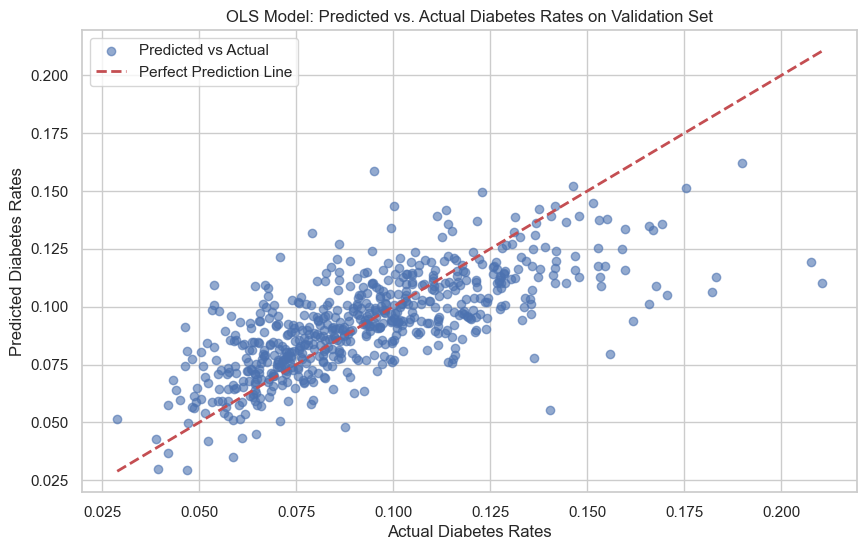

In [100]:
import matplotlib.pyplot as plt

# Scatter plot for Actual vs. Predicted values on validation set
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6, color='b', label='Predicted vs Actual')

# Add a line for perfect predictions
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction Line')

# Add labels and title
plt.xlabel("Actual Diabetes Rates")
plt.ylabel("Predicted Diabetes Rates")
plt.title("OLS Model: Predicted vs. Actual Diabetes Rates on Validation Set")
plt.legend()
plt.show()

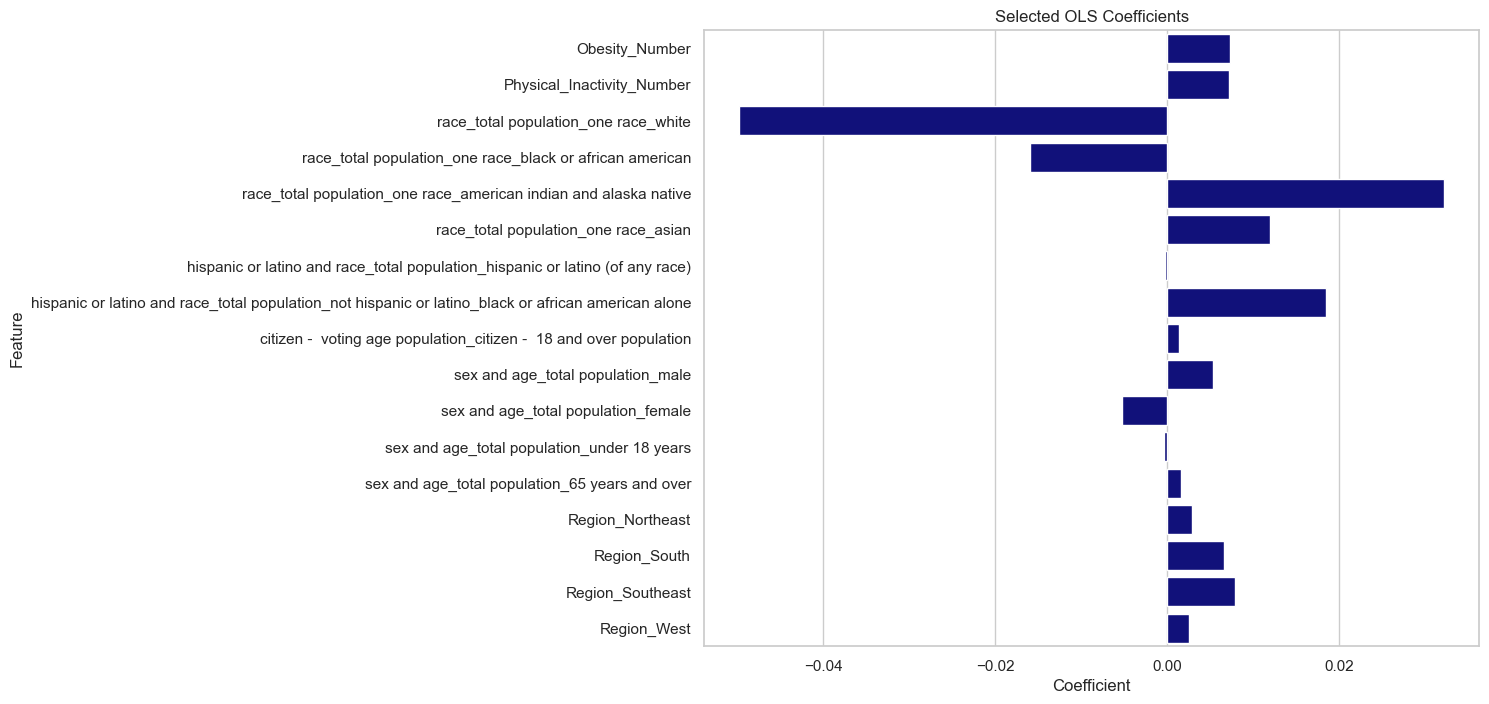

In [102]:
# Expanded list of relevant features for diabetes prediction
selected_features = [
    'Obesity_Number', 
    'Physical_Inactivity_Number', 
    'sex and age_total population_65 years and over', 
    'race_total population_one race_white', 
    'race_total population_one race_black or african american',
    'race_total population_one race_asian', 
    'race_total population_one race_american indian and alaska native',
    'hispanic or latino and race_total population_hispanic or latino (of any race)',
    'hispanic or latino and race_total population_not hispanic or latino_black or african american alone',
    'citizen -  voting age population_citizen -  18 and over population', 
    'sex and age_total population_under 18 years',
    'sex and age_total population_65 years and over', 
    'sex and age_total population_male',
    'sex and age_total population_female',
    'Region_West', 
    'Region_South', 
    'Region_Southeast', 
    'Region_Northeast'
]

# Filter the OLS coefficients DataFrame to include only the selected features
ols_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ols_model.coef_
})

# Filter for selected features
filtered_ols_coefficients = ols_coefficients[ols_coefficients['Feature'].isin(selected_features)]

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=filtered_ols_coefficients, x='Coefficient', y='Feature', color="darkblue")
plt.title('Selected OLS Coefficients')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.show()


##### Summary Statistics: MSE on the validation set is approximately 0.000402, this gives a sense of the average squared difference between predicted and actual diabetes rates. R2 was about 0506, which indicates that around 50.6% of the variance in diabetes rates across counties is explained by this OLS model.

##### Scatter plot: Points closely aligned with the red line (the "perfect prediction line") indicate more accurate predictions, while greater deviations indicate errors. The scatter plot shows a broad spread around the perfect prediction line, highlighting instances where the model might struggle with certain predictions.

##### Coefficient Analysis: I took the important feature to reflect on the bar plot such as obesity number, physical inactivity, regional influence, and some of the demographic factors such as age, sex, race, etc. The rationale for showing only these variables on the bar plot as these features are among the strongest predictors of diabetes rates in this dataset.

#### Model 2:  RIDGE

In [104]:
#
# Run the RIDGE Model 

# Import necessary libraries
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Ridge model with a chosen alpha (penalty term)
ridge_model = Ridge(alpha=0.1)

# Fit the model on the training data
ridge_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred_ridge = ridge_model.predict(X_val)

# Evaluate the model on the validation set
mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)
r2_ridge = r2_score(y_val, y_val_pred_ridge)

# Print evaluation metrics for Ridge model
print("Ridge Model Evaluation on Validation Set:")
print("Mean Squared Error (MSE):", mse_ridge)
print("R-squared (R2):", r2_ridge)


Ridge Model Evaluation on Validation Set:
Mean Squared Error (MSE): 0.0004020825344993841
R-squared (R2): 0.5060641893812954


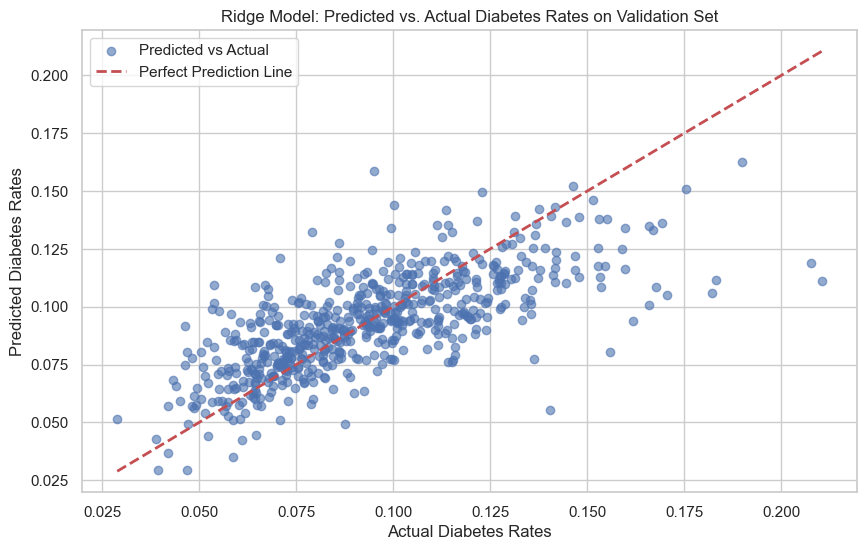

In [106]:
#Ridge Model - Scatter Plot of Predicted vs. Actual
import matplotlib.pyplot as plt

# Scatter plot for Actual vs. Predicted values on validation set
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred_ridge, alpha=0.6, color='b', label='Predicted vs Actual')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel("Actual Diabetes Rates")
plt.ylabel("Predicted Diabetes Rates")
plt.title("Ridge Model: Predicted vs. Actual Diabetes Rates on Validation Set")
plt.legend()
plt.show()

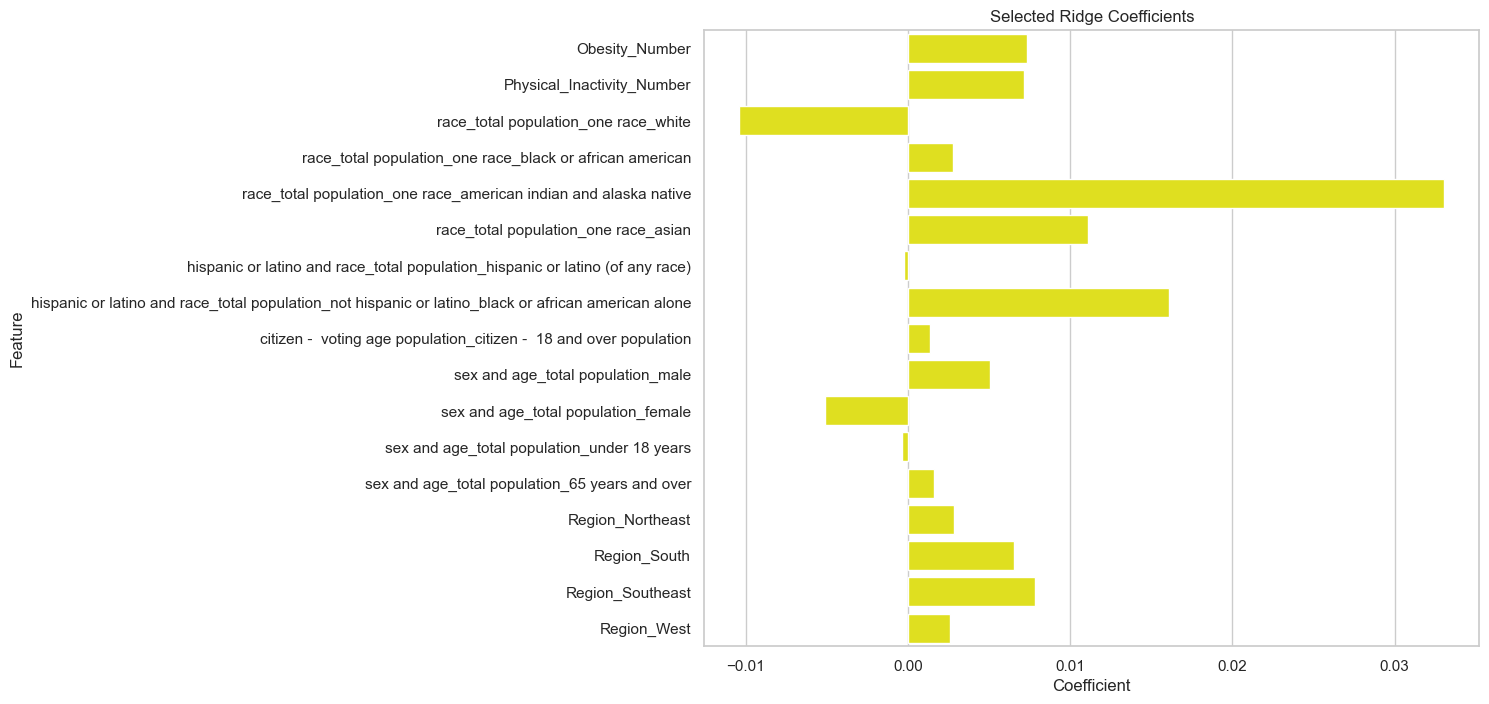

In [108]:
#Ridge Model - Coefficient Plot for Selected Features
import seaborn as sns
import pandas as pd

# Create a DataFrame of Ridge coefficients
ridge_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_model.coef_
})

# Filter for selected features to make the plot clearer
filtered_ridge_coefficients = ridge_coefficients[ridge_coefficients['Feature'].isin(selected_features)]

# Plot the coefficients
plt.figure(figsize=(10, 8))
sns.barplot(data=filtered_ridge_coefficients, x='Coefficient', y='Feature', color="yellow")
plt.title("Selected Ridge Coefficients")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

##### Summary Statistics: MSE on the validation set is approximately 0.000401 (which is very close to OLS). R2 was about 05061, which indicates around 50.61% of the variance in diabetes rates across counties again this is very close to OLS. 

##### Scatter plot: The scatter plot comparing predicted versus actual diabetes rates on the validation set shows that most data points align closely with the red dashed line (representing a perfect prediction). This alignment further supports that the Ridge model is capturing the underlying patterns in the data reasonably well, though some scatter is expected given the R² of about 50.6%

##### Coefficient Analysis: I observe the same features as OLS to maintain consistency and those features are the also strongest predictors of diabetes rates in this dataset.

#### Model 3: LASSO Model

In [110]:
#
# Run the LASSO Model
# Import necessary libraries
from sklearn.linear_model import Lasso

# Initialize the Lasso model with a chosen alpha (penalty term)
lasso_model = Lasso(alpha=0.0001, max_iter=10000)

# Fit the model on the training data
lasso_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred_lasso = lasso_model.predict(X_val)

# Evaluate the model on the validation set
mse_lasso = mean_squared_error(y_val, y_val_pred_lasso)
r2_lasso = r2_score(y_val, y_val_pred_lasso)

# Print evaluation metrics for Lasso model
print("Lasso Model Evaluation on Validation Set:")
print("Mean Squared Error (MSE):", mse_lasso)
print("R-squared (R2):", r2_lasso)


Lasso Model Evaluation on Validation Set:
Mean Squared Error (MSE): 0.0003893726930284135
R-squared (R2): 0.5216775157786115


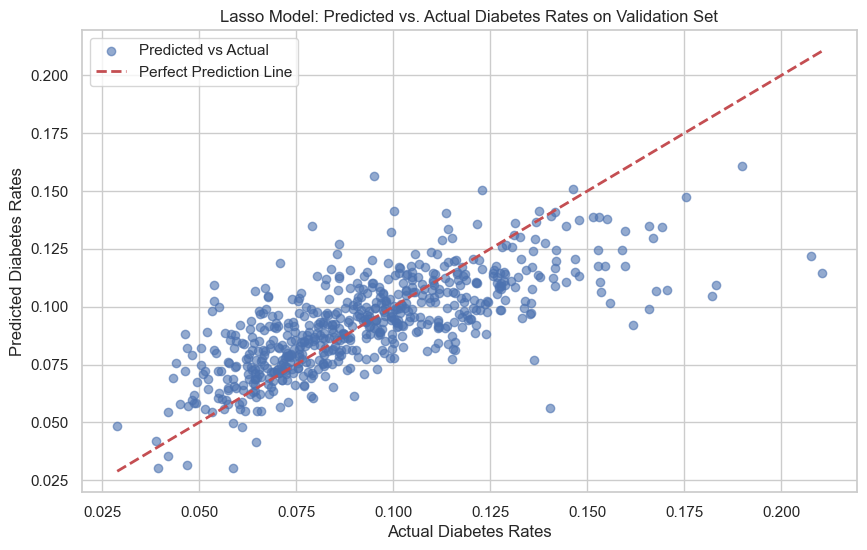

In [114]:
#LASSO Model - Scatter Plot of Predicted vs. Actual
# Scatter plot for Actual vs. Predicted values on validation set
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred_lasso, alpha=0.6, color='b', label='Predicted vs Actual')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel("Actual Diabetes Rates")
plt.ylabel("Predicted Diabetes Rates")
plt.title("Lasso Model: Predicted vs. Actual Diabetes Rates on Validation Set")
plt.legend()
plt.show()


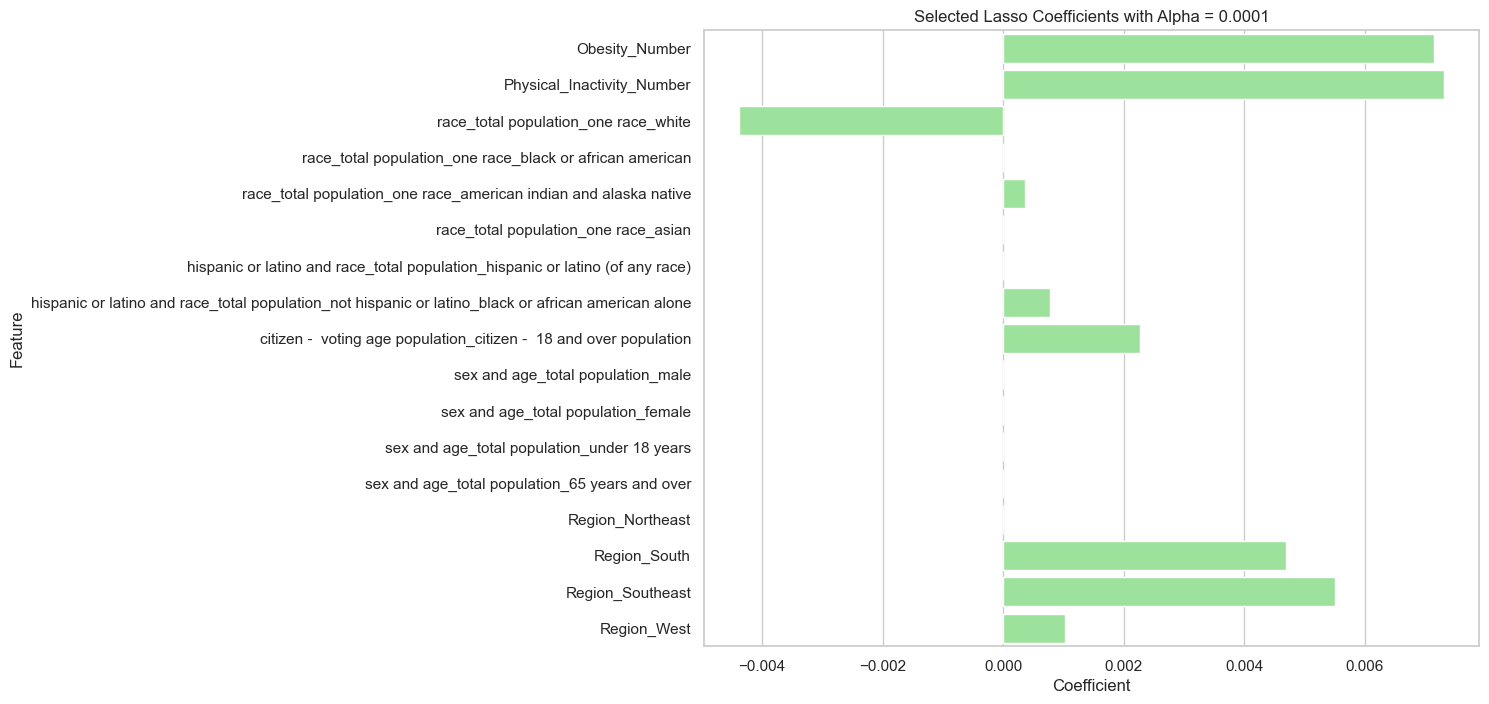

In [116]:
#LASSO Model - Coefficient Plot for Selected Features
#Adjusted alpha Value to make sure the model takes more coefficient (alpha 0.001)
from sklearn.linear_model import Lasso

# Initialize the Lasso model with a smaller alpha value
lasso_model = Lasso(alpha=0.0001, max_iter=10000)

# Fit the Lasso model on the training data
lasso_model.fit(X_train, y_train)

# Create a DataFrame of Lasso coefficients
lasso_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_model.coef_
})

# Filter for selected features to make the plot clearer
filtered_lasso_coefficients = lasso_coefficients[lasso_coefficients['Feature'].isin(selected_features)]

# Plot the coefficients
plt.figure(figsize=(10, 8))
sns.barplot(data=filtered_lasso_coefficients, x='Coefficient', y='Feature', color="lightgreen")
plt.title("Selected Lasso Coefficients with Alpha = 0.0001")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.show()

##### Summary Statistics: MSE on the validation set is approximately 0.0003894. R2 was about 0.5217, which indicates around 52.17% of the variance in diabetes rates across counties. MSE for the lasso model is slightly lower than the ridge and OLS models, indicating lasso prediction is closer to the actual values

##### Scatter plot: The scatter plot for Lasso’s predicted vs. actual values shows a tight clustering along the perfect prediction line, particularly at lower diabetes rates, indicating that the model performs well for typical counties with lower diabetes prevalence. However, there is some deviation at higher values, suggesting that the model may underpredict for counties with extremely high diabetes rates, a common occurrence when using Lasso due to its regularization effect.

##### Coefficient Analysis: Lasso regression inherently performs feature selection by penalizing the coefficients of less important features, shrinking some of them to zero based on the chosen alpha. With an alpha of 0.0001, the model selected a focused subset of features as shown in the coefficient plot. 

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

In [118]:
#
# Predict on validation data
## Calculate the Mean Squared Error (MSE) and R-squared (R²) for each model's predictions.
from sklearn.metrics import mean_squared_error, r2_score

# OLS Model Prediction on Validation Set
y_val_pred_ols = ols_model.predict(X_val)
mse_ols = mean_squared_error(y_val, y_val_pred_ols)
r2_ols = r2_score(y_val, y_val_pred_ols)

print("OLS Model Evaluation on Validation Set:")
print("MSE:", mse_ols)
print("R²:", r2_ols)

# Ridge Model Prediction on Validation Set
y_val_pred_ridge = ridge_model.predict(X_val)
mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)
r2_ridge = r2_score(y_val, y_val_pred_ridge)

print("Ridge Model Evaluation on Validation Set:")
print("MSE:", mse_ridge)
print("R²:", r2_ridge)

# Lasso Model Prediction on Validation Set
y_val_pred_lasso = lasso_model.predict(X_val)
mse_lasso = mean_squared_error(y_val, y_val_pred_lasso)
r2_lasso = r2_score(y_val, y_val_pred_lasso)

print("Lasso Model Evaluation on Validation Set:")
print("MSE:", mse_lasso)
print("R²:", r2_lasso)

OLS Model Evaluation on Validation Set:
MSE: 0.00040245912696239825
R²: 0.5056015666918432
Ridge Model Evaluation on Validation Set:
MSE: 0.0004020825344993841
R²: 0.5060641893812954
Lasso Model Evaluation on Validation Set:
MSE: 0.0003893726930284135
R²: 0.5216775157786115


##### LASSO model has the lowest Mean Squared Error(MSE). It has the smallest average squared error on the validation set, making it slightly better in terms of minimizing prediction error.R² is highest for the Lasso model at 0.5217, meaning it explains about 52.17% of the variance in the validation set. Lasso outperforms Ridge and OLS, likely because it can perform feature selection by setting some coefficients to zero, reducing the model’s complexity while retaining relevant features.

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [120]:
#
# Predict using your best model

# Import necessary libraries
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Initialize Lasso with the best alpha 
best_alpha = 0.001  # Adjust if necessary based on tuning
lasso_model_final = Lasso(alpha=best_alpha)

# Combine training and validation sets
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Fit the model on the combined training and validation data
lasso_model_final.fit(X_train_val, y_train_val)

# Predict on the test set
y_test_pred = lasso_model_final.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print test set evaluation metrics
print("Lasso Model Evaluation on Test Set:")
print("Mean Squared Error (MSE):", mse_test)
print("R-squared (R2):", r2_test)

Lasso Model Evaluation on Test Set:
Mean Squared Error (MSE): 0.00041475726638474106
R-squared (R2): 0.45398722950030634


##### Lasso model has a MSE of approximately 0.000415 and R2 score of about 0.454 on the test set. The slight drop in R2 to 0.454 on the test set indicates a bit of overfitting. MSE has increased slightly, indicating a small decrease in the accuracy of the test data.The model’s predictive power (45.4%) may be sufficient to guide a pilot program but suggests that predictions should be taken with some caution as there’s still a moderate degree of unexplained variance.

### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [122]:
#
# Run cross-validation
# Import necessary libraries
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Define the number of folds for cross-validation
k = 5

# Set up k-fold cross-validation with shuffling to ensure diverse splits
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation for MSE and R-squared
# Note: cross_val_score returns negative MSE, so we'll negate it to get positive MSE
mse_scores = -cross_val_score(lasso_model_final, X_train_val, y_train_val, cv=kf, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(lasso_model_final, X_train_val, y_train_val, cv=kf, scoring='r2')

# Calculate and print average performance metrics across all folds
mean_mse_cv = np.mean(mse_scores)
mean_r2_cv = np.mean(r2_scores)

print(f"Lasso Model {k}-Fold Cross-Validation Results:")
print("Average Mean Squared Error (MSE):", mean_mse_cv)
print("Average R-squared (R2):", mean_r2_cv)

Lasso Model 5-Fold Cross-Validation Results:
Average Mean Squared Error (MSE): 0.0004140385046464983
Average R-squared (R2): 0.47706584906070904


##### The cross-validation MSE (0.0004140) is very close to the test set MSE (0.0004148). This means that the model generalizes well and performs consistently across different data subsets. The cross-validation and test set results are similar, this indicates that the Lasso model’s predictions are robust and not heavily dependent on a particular data split.

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

##### Bias-variance tradeoff is an important concept in machine learning that describes the balance between two types of errors that affect a model's performance: bias and variance. Bias refers to errors due to overly simplistic assumptions in the model, leading to underfitting. High bias means the model has not learned enough from the training data, resulting in poor predictions. Variance refers to errors from overly complex models that capture noise in the training data, leading to overfitting. High variance means the model is sensitive to minor fluctuations in the training data and may not generalize well.

##### This tradeoff is relevant to this problem because we aim to predict diabetes rates across counties accurately. A model with high bias would fail to capture important patterns, such as regional differences in demography indicators like sex, age etc. Conversely, a model with high variance would perform well on training data but poorly on new data, making it unreliable for predicting diabetes rates in unseen counties. In the analysis, techniques like cross-validation and regularization (using Lasso) helped us manage this tradeoff by finding a model that generalizes well without overfitting or underfitting.

2. Define overfitting, and why it matters for machine learning. How can we address it?

##### Overfitting occurs when a machine learning model learns the noise and specific patterns in the training data rather than capturing the general underlying trend. This results in a model that performs well on training data but poorly on unseen data. Overfitting is problematic because it reduces a model’s ability to generalize to new data, making predictions less reliable.

##### Overfitting matters in this problem because our goal is to predict diabetes rates across different counties, which are likely to vary in ways that were not fully represented in the training data. To address overfitting, we used regularization techniques like Lasso regression, which penalizes large coefficients, thereby reducing the model’s complexity. Additionally, we employed cross-validation, allowing us to evaluate model performance across multiple data splits and identify a model that generalizes well. These approaches help produce a model that is better suited for real-world applications by focusing on predictive patterns instead of noise.

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

##### I used several predictive models, including OLS, Ridge, and Lasso regression, to predict diabetes rates across counties. Through cross-validation, we found that the Lasso model provided the best performance, balancing model complexity with predictive accuracy. The model identified key predictors, such as obesity and physical inactivity, that strongly correlate with diabetes rates. Additionally, certain regional indicators appeared significant, suggesting that counties in regions like the Southeast might have higher diabetes rates due to lifestyle, demographic factors, etc. 

##### For a diabetes prevention program, I would prioritize counties in the Southeast and South regions, where higher diabetes rates were predicted. These areas may benefit most from interventions targeting lifestyle factors like physical activity and obesity. Incorporating features such as race, gender, and age composition could further refine the model. For example, considering the higher risk of diabetes in older adults or specific racial groups may reveal additional priority areas for intervention. By adjusting the model to account for demographic variations, we can make recommendations that are more sensitive to the unique population characteristics of each county.

##### Deploying this model in a real-world application would be feasible and beneficial, though with caution. The model performs consistently across validation and test sets, indicating that it can generalize well to new data. However, predictions should be supplemented with local knowledge to ensure the model's recommendations align with each county's unique demographic and health profiles. Furthermore, regular retraining with updated data will be necessary to maintain accuracy, especially if demographic or behavioral shifts occur. Thus, while this model provides a strong foundation for identifying high-priority counties, it should be used as a guide in conjunction with on-the-ground insights.